<a href="https://colab.research.google.com/github/JuhyeongKi/practice_123/blob/main/Deep_Learning_with_PyTorch_ImageSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1 : Set up colab gpu runtime environment

In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-s4adnp6u
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-s4adnp6u


# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [2]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

fatal: destination path 'Human-Segmentation-Dataset-master' already exists and is not an empty directory.


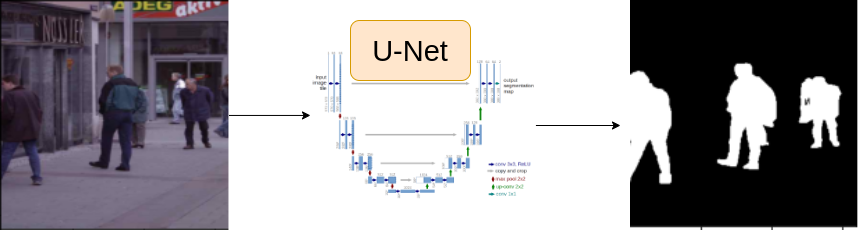

# Some Common Imports

In [3]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [4]:
import torch 
import cv2

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [35]:
csv_path = "/content/Human-Segmentation-Dataset-master/train.csv" # masks, images가 작성된 csv경로(input, target으로 생각)
data_path = "/content/" # 학습에 사용할 imageset 경로

DEVICE = 'cuda'       # 이거 가지고 나중에 GPU를 사용할거임
EPOCHS = 30           # 전체 dataset을 몇번 학습할 것인가에 대한 내용
lr = 0.003            # learning rate로 학습률인데, 가중치(w)를 업데이트 할때 얼마만큼 최소값에 도달할건지를 곱해주는 스칼라 값으로 -> 너무 크면 발산하고, 너무 작으면 학습이 제대로 되지 않는다. 적절한 값을 찾도록 공부해보자.
IMG_SIZE = 320        # image size -> (320x320 pixel 이런식)
BATCH_SIZE = 16       # 전체 data set에서 16개씩 쪼개서 넣음
ENCODER = 'resnet18'  # encoder -> feature를 추출할때 사용하는 분류 모델
WEIGHTS = 'imagenet'  # pretraining on 'imagenet'

In [40]:
df['images'][0] #images 경로

'Human-Segmentation-Dataset-master/Training_Images/1.jpg'

In [41]:
df['masks'][0] #masks 경로

'Human-Segmentation-Dataset-master/Ground_Truth/1.png'

In [6]:
# csv파일을 dataframe로 불러와서 확인

df = pd.read_csv(csv_path)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [47]:
# Normalization을 위한 확인 과정
abc = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

print(np.min(abc))
print(np.max(abc))

0
255


In [7]:
# 첫번째 줄 image, mask불러와서 min-max normalization함 -> (최대:255 - 최소:0)로 나눠서

row = df.iloc[0]

image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0    # min:0, max:255값임

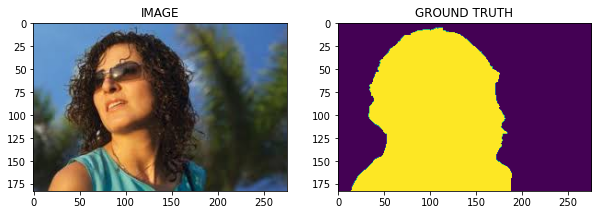

In [8]:
# imshow를 통해 

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask) #cmap = 'gray')

In [9]:
# dataframe을 train, val로 분리함 / 8:2 / random_state에서 지정한 숫자를 동일하게 하면 매번 같은 데이터로 분리됨

train_df, val_df = train_test_split(df, test_size=0.2, random_state = 42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [10]:
import albumentations as A      # augmentation을 쉽게 해주는 라이브러리

In [11]:
def get_train_augs():
  return A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE), # 지정 사이즈로 resize
        A.HorizontalFlip(p=0.5),      # 50% 확률로 수평으로 접기
        A.VerticalFlip(p=0.5)         # 50% 확률로 수직으로 접기           
  ])

def get_valid_augs():
  return A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE),  # 지정 사이즈로 resize
  ])

# Task 4 : Create Custom Dataset 

In [12]:
from torch.utils.data import Dataset

In [13]:
# 여기에서 dataset 전처리? 하는 방법 SegmentationDataset으로 설정(불러와서, 크기 맞추고, augmentation하고, 형변환 하고, normalize하고 반환)

class SegmentationDataset(Dataset):
  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations
    
  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):

    row = self.df.iloc[idx]

    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) #(h, w, c)
    mask = np.expand_dims(mask, axis = -1)

    if self.augmentations:
      data = self.augmentations(image= image, mask = mask)
      image = data['image']
      mask = data['mask']

    # (h, w, c) -> (c, h, w)
    image = np.transpose(image, (2,0,1)).astype(np.float32)
    mask = np.transpose(mask, (2,0,1)).astype(np.float32)

    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask) / 255.0)

    return image, mask

In [14]:
# 위에서 class사용해서 각각 dataset으로 저장

trainset = SegmentationDataset(train_df, get_train_augs())
valset = SegmentationDataset(val_df, get_train_augs())

In [15]:
# 갯수 확인해 주고

print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(valset)}")

Size of Trainset : 232
Size of Validset : 58


In [16]:
# shape한번 확인해 주고

trainset[1][1].shape

torch.Size([1, 320, 320])

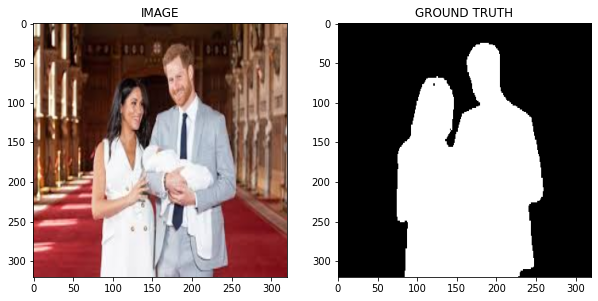

In [17]:
# image, mask sample로 한개 불러와서 확인

idx = 20

image, mask = trainset[idx]
helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [18]:
from torch.utils.data import DataLoader

In [19]:
# dataset에 저장된 data들을 batch_size, shuffle에 맞게끔 불러와서 train val loader에 저장

trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
valloader = DataLoader(valset, batch_size = BATCH_SIZE)

In [20]:
# trainset이 232였고, batch_size가 16이니까 trainloader는 15 _ drop last를 사용하지 않았기 때문에 마지막 batch size는 8 이 될듯. (train 기준)

print (f'total no. of batches in trainloader : {len(trainloader)}')
print (f'total no. of batches in valloader : {len(valloader)}')

total no. of batches in trainloader : 15
total no. of batches in valloader : 4


In [21]:
# trainloader에 저장된거 반복문 통해서 한개만 불러와서 size check.

for image, mask in trainloader:
  break

print(f"One batch image shape:{image.shape}")
print(f"One batch mask shape:{mask.shape}")

One batch image shape:torch.Size([16, 3, 320, 320])
One batch mask shape:torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [22]:
from torch import nn                                      # torch는 써야지
import segmentation_models_pytorch as smp                 # model도 라이브러리가 다 있다. 좋은 세상이다.
from segmentation_models_pytorch.losses import DiceLoss   # loss 사용할거 import

In [23]:
# segmentation model을 아주 간편하게 짤 수 있다.
# 처음에 위에서 지정한 ENCODER: resnet18, WEIGHT: imagenet
# in channels=3 부터(default)(R,G,B) 시작
# classes = 1 -> output 1개
# loss 함수는 Diceloss + BCEWith~(BCEloss+sigmoid)

class SegmentationModel(nn.Module):
  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.arc = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights = WEIGHTS,
        in_channels = 3,
        classes = 1,
        activation = None
    )
  def forward(self, images, masks = None):

    logits = self.arc(images)

    if masks != None:
      loss1 = DiceLoss(mode = "binary")(logits, masks)
      loss2 = nn.BCEWithLogitsLoss()(logits, masks)
      return logits, loss1 + loss2

    return logits

In [24]:
# 위에서 작성한 segmentationModel을 model로 정의하고
# cuda로 호출한다. <- 이 부분을 해줘야 cuda에서 돌아간다.

model = SegmentationModel()
model.to(DEVICE); 

# Task 7 : Create Train and Validation Function 

In [25]:
# train 과정 정의
# 위에서 모델을 정의 했으니 이제 data를 모델로 넣어서 학습을 통해 model의 weight를 업데이트 해줘야 한다.
# dataloader의 image와 mask를 불러서 학습을 진행하고
# 각 반복때 마다 gradient를 초기화 해주고 backward를 계산하고
# step에서 업데이트해줍니다.
# loss.item으로 각단계의 loss값을 업데이트 해 줍니다.

def train_fn(data_loader, model, optimizer):

  model.train()
  total_loss = 0.0
  
  for images, masks in tqdm(data_loader):

    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(data_loader)

In [26]:
# val에서는 학습을 하는게 아니고
# 학습된 model이 잘 작동하는지 평가하는 곳 입니다.
# loss 값을 업데이트 출력해 줍니다.

def eval_fn(data_loader, model):

  model.eval()
  total_loss = 0.0
  
  with torch.no_grad():
    for images, masks in tqdm(data_loader):

      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      logits, loss = model(images, masks)
      
      total_loss += loss.item()

  return total_loss / len(data_loader)

# Task 8 : Train Model

In [27]:
# optimizer는 여러 종류가 있지만 Adam을 사용합니다.

optimizer = torch.optim.Adam(model.parameters(),lr=lr)

In [28]:
# best_valid_loss를 np.Inf로 정의 했는데, 소숫점 무한대가 나올 수 있어서 그런것으로 생각됩니다.
# val_loss가 최저점이 될 때마다 best_model.pt에 저장해줍니다.

# 나머지는 그냥 훈련 및 검증 단계를 print해 줍니다.

best_valid_loss = np.Inf

for i in range(EPOCHS):
  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(valloader, model)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')

    print('SAVED_MODEL')
    best_valid_loss = valid_loss

  print(f"EPOCH: {i+1} Train_loss: {train_loss} Valid_loss:{valid_loss}")

100%|██████████| 4/4 [00:02<00:00,  1.82it/s]


SAVED_MODEL
EPOCH: 1 Train_loss: 0.6861372113227844 Valid_loss:0.9080540835857391


100%|██████████| 4/4 [00:01<00:00,  2.70it/s]


SAVED_MODEL
EPOCH: 2 Train_loss: 0.36391571362813313 Valid_loss:0.31282999366521835


100%|██████████| 4/4 [00:01<00:00,  2.64it/s]


SAVED_MODEL
EPOCH: 3 Train_loss: 0.2530202051003774 Valid_loss:0.25067027285695076


100%|██████████| 4/4 [00:01<00:00,  2.66it/s]


EPOCH: 4 Train_loss: 0.2472577800353368 Valid_loss:0.26035382598638535


100%|██████████| 4/4 [00:01<00:00,  2.71it/s]


EPOCH: 5 Train_loss: 0.2479209154844284 Valid_loss:0.3178768903017044


100%|██████████| 4/4 [00:01<00:00,  2.71it/s]


EPOCH: 6 Train_loss: 0.21576698621114096 Valid_loss:0.26217301934957504


100%|██████████| 4/4 [00:01<00:00,  2.71it/s]


EPOCH: 7 Train_loss: 0.20615857938925425 Valid_loss:0.26473625376820564


100%|██████████| 4/4 [00:01<00:00,  2.69it/s]


EPOCH: 8 Train_loss: 0.2665618280569712 Valid_loss:0.3621179163455963


100%|██████████| 4/4 [00:01<00:00,  2.71it/s]


SAVED_MODEL
EPOCH: 9 Train_loss: 0.1826526348789533 Valid_loss:0.1910850740969181


100%|██████████| 4/4 [00:01<00:00,  2.72it/s]


SAVED_MODEL
EPOCH: 10 Train_loss: 0.15461821456750233 Valid_loss:0.17725994810461998


100%|██████████| 4/4 [00:01<00:00,  2.71it/s]


EPOCH: 11 Train_loss: 0.13766533633073172 Valid_loss:0.18422037735581398


100%|██████████| 4/4 [00:01<00:00,  2.71it/s]


SAVED_MODEL
EPOCH: 12 Train_loss: 0.13493689447641372 Valid_loss:0.17070793733000755


100%|██████████| 4/4 [00:01<00:00,  2.69it/s]


EPOCH: 13 Train_loss: 0.16623295644919078 Valid_loss:0.20747900754213333


100%|██████████| 4/4 [00:01<00:00,  2.71it/s]


EPOCH: 14 Train_loss: 0.14343606730302175 Valid_loss:0.19242700934410095


100%|██████████| 4/4 [00:01<00:00,  2.69it/s]


EPOCH: 15 Train_loss: 0.1773430878917376 Valid_loss:0.23339177295565605


100%|██████████| 4/4 [00:01<00:00,  2.74it/s]


EPOCH: 16 Train_loss: 0.17991799066464106 Valid_loss:0.2487872689962387


100%|██████████| 4/4 [00:01<00:00,  2.71it/s]


EPOCH: 17 Train_loss: 0.15054703404506048 Valid_loss:0.18866854533553123


100%|██████████| 4/4 [00:01<00:00,  2.73it/s]


EPOCH: 18 Train_loss: 0.14931627859671912 Valid_loss:0.22579088807106018


100%|██████████| 4/4 [00:01<00:00,  2.72it/s]


EPOCH: 19 Train_loss: 0.1043761819601059 Valid_loss:0.18217147514224052


100%|██████████| 4/4 [00:01<00:00,  2.70it/s]


EPOCH: 20 Train_loss: 0.10884550164143245 Valid_loss:0.1888539306819439


100%|██████████| 4/4 [00:01<00:00,  2.73it/s]


EPOCH: 21 Train_loss: 0.14083261539538702 Valid_loss:0.24253106489777565


100%|██████████| 4/4 [00:01<00:00,  2.72it/s]


EPOCH: 22 Train_loss: 0.12965850830078124 Valid_loss:0.2727256752550602


100%|██████████| 4/4 [00:01<00:00,  2.71it/s]


EPOCH: 23 Train_loss: 0.12164492160081863 Valid_loss:0.18000265583395958


100%|██████████| 4/4 [00:01<00:00,  2.69it/s]


EPOCH: 24 Train_loss: 0.10826899508635203 Valid_loss:0.19846674427390099


100%|██████████| 4/4 [00:01<00:00,  2.70it/s]

EPOCH: 25 Train_loss: 0.1245503788193067 Valid_loss:0.22950623370707035


# Task 9 : Inference

In [33]:
# best 값이 저장된 파일로 model를 불러오고
# valset을 통해 outputdmf 확인해 봅니다.
# 아래를 보면 output이 괜찮은 것으로 보입니다.

# 보통 testset을 분리하거나 다른데이터를 추가해서 inference를 하는데 이 강의에서는 data가 부족해서 valset으로 하지 않았나 생각됩니다.

idx = 2

model.load_state_dict(torch.load("/content/best_model.pt"))

image, mask = valset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0)) #(C, H, W) -> (1, C, H, W)
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5)*1.0

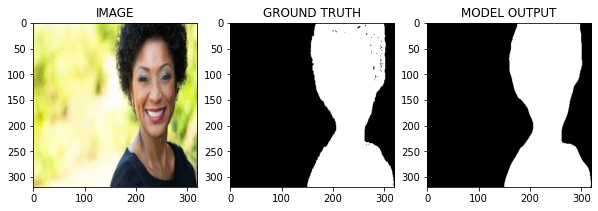

In [34]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya